# Tutorial on Building Fair AI Models

## Presenter: Adrin Jalali, Ancud-IT Beratung
### https://developer.ibm.com/opentech/wp-content/uploads/sites/43/2018/11/sch-aif360-2018-11-07.pdf
### https://github.com/adrinjalali/aif360_tutorial
### [Conscientious Classification: A Data Scientist's Guide to Discrimination-Aware Classification](https://www.liebertpub.com/doi/10.1089/big.2016.0048)

## PyData Berlin, REVISION, 2018

<a id="toc"></a>

# Agenda
## 1. Summary
## 2. Data
## 3. Train/Test a Model
### 3.1. Load the data
### 3.2. Naive
### 3.3. Preprocessing - Reweighing
### 3.4. In-process technique - Prejudice Remover
### 3.5. Preprocessing - Disparate Impact Remover

<a id="summary"></a>

## 1. Summary

The notebook demonstrates how a variety of fairness metrics and bias mitigation algorithms can used to detect and reduce bias when learning classifiers.

Additional information is available in the accompanying [presentation](https://github.com/monindersingh/pydata2018_fairAI_models_tutorial/blob/master/pydata_nyc_2018_building_fair_AI_models.pdf).

An open source Python toolkit, [AI Fairness 360 (AIF360)](https://github.com/IBM/AIF360), is used for this demonstration. This toolkit provides additional [examples](https://github.com/IBM/AIF360/tree/master/examples) of bias detection/mitigation as well as [guidance](http://aif360.mybluemix.net/resources#guidance) figuring out what metrics and algorithms will be most apropriate for a given problem.

Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.

Bias mitigation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).


<a id="use_case"></a>

## 2. Data used

#### Medical Expenditure Panel Survey (MEPS) data

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181).

The sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that includes everyone else. 

To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15, the number of office based visits;  OPTOTV15, the number of outpatient visits; ERTOT15, the number of ER visits;  IPNGTD15, the number of inpatient nights, and  + HHTOTD16, the number of home health visits.

The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). Such people can be selected for case management and provided additional resources. High utilization respondents constituted around 17% of each dataset.



In [1]:
# Load all necessary packages
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

#Datasets
from aif360.datasets.meps_dataset_panel19_fy2015 import MEPSDataset19

#Fairness Metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

#Bias Mitigation Techniques
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.prejudice_remover import PrejudiceRemover
from aif360.algorithms.preprocessing import DisparateImpactRemover

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

### Metrics

average odds difference := $\tfrac{1}{2}\left[(FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}) + (TPR_{D = \text{privileged}} - TPR_{D = \text{unprivileged}}))\right]$
           
statistical parity difference := $Pr(\hat{Y} = 1 | D = \text{unprivileged}) - Pr(\hat{Y} = 1 | D = \text{privileged})$
           
equal opportunity difference := $TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}$

theil index := $\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln\frac{b_{i}}{\mu}, \text{with} b_i = \hat{y}_i - y_i + 1$

disparate impact := $\frac{Pr(Y = 1 | D = \text{unprivileged})} {Pr(Y = 1 | D = \text{privileged})}$

## Helper Functions

In [2]:
#Validate model on given dataset and find threshold for best balanced accuracy
def validate_visualize(dataset, y_pred_proba):
    thresh_arr = np.linspace(0.01, 0.7, 50)

    bal_acc_arr = []
    disp_imp_arr = []
    avg_odds_diff_arr = []
    stat_par_diff = []
    eq_opp_diff = []
    theil_ind = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_pred_proba[:,1] > thresh).astype(np.double)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

        TPR = classified_metric.true_positive_rate()
        TNR = classified_metric.true_negative_rate()
        bal_acc = 0.5*(TPR+TNR)

        acc = accuracy_score(y_true=dataset.labels,
                             y_pred=dataset_pred.labels)
        bal_acc_arr.append(bal_acc)
        avg_odds_diff_arr.append(classified_metric.average_odds_difference())
        disp_imp_arr.append(metric_pred.disparate_impact())
        stat_par_diff.append(classified_metric.statistical_parity_difference())
        eq_opp_diff.append(classified_metric.equal_opportunity_difference())
        theil_ind.append(classified_metric.theil_index())


    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

    avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

    stat_par_diff_at_best_bal_acc = stat_par_diff[thresh_arr_best_ind]
    eq_opp_diff_at_best_bal_acc = eq_opp_diff[thresh_arr_best_ind]
    theil_ind_at_best_bal_acc = theil_ind[thresh_arr_best_ind]
    
    #Plot balanced accuracy, abs(1-disparate impact)
    %matplotlib inline

    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(thresh_arr, bal_acc_arr)
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)


    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
    ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
                color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(thresh_arr, bal_acc_arr)
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)


    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
    ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

    print("Threshold corresponding to Best balanced accuracy: %6.4f" % thresh_arr_best)
    print("Best balanced accuracy: %6.4f" % best_bal_acc)
    print("Corresponding abs(1-disparate impact) value: %6.4f" % disp_imp_at_best_bal_acc)
    print("Corresponding average odds difference value: %6.4f" % avg_odds_diff_at_best_bal_acc)
    print("Corresponding statistical parity difference value: %6.4f" % stat_par_diff_at_best_bal_acc)
    print("Corresponding equal opportunity difference value: %6.4f" % eq_opp_diff_at_best_bal_acc)
    print("Corresponding Theil index value: %6.4f" % theil_ind_at_best_bal_acc)
    return thresh_arr_best

In [3]:
#Evaluate performance of a given model with a given threshold on a given dataset

def validate_test(dataset, y_pred_proba, threshold):
    y_pred = (y_pred_proba[:,1] > threshold).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred

    classified_metric = ClassificationMetric(dataset, 
                                            dataset_pred,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)

    acc = accuracy_score(y_true=dataset.labels,
                        y_pred=dataset_pred.labels)

    #get results
    best_bal_acc = bal_acc
    disp_imp_at_best_bal_acc = np.abs(1.0-metric_pred.disparate_impact())
    avg_odds_diff_at_best_bal_acc = classified_metric.average_odds_difference()
    stat_par_diff_at_best_bal_acc = classified_metric.statistical_parity_difference()
    eq_opp_diff_at_best_bal_acc = classified_metric.equal_opportunity_difference()
    theil_ind_at_best_bal_acc = classified_metric.theil_index()
    
    print("Threshold corresponding to Best balanced accuracy: %6.4f" % threshold)
    print("Best balanced accuracy: %6.4f" % best_bal_acc)
    print("Corresponding abs(1-disparate impact) value: %6.4f" % disp_imp_at_best_bal_acc)
    print("Corresponding average odds difference value: %6.4f" % avg_odds_diff_at_best_bal_acc)
    print("Corresponding statistical parity difference value: %6.4f" % stat_par_diff_at_best_bal_acc)
    print("Corresponding equal opportunity difference value: %6.4f" % eq_opp_diff_at_best_bal_acc)
    print("Corresponding Theil index value: %6.4f" % theil_ind_at_best_bal_acc)
    
    return {"best_bal_acc": best_bal_acc,
            "disp_imp": disp_imp_at_best_bal_acc,
            "avg_odds_diff": avg_odds_diff_at_best_bal_acc,
            "stat_par_diff": stat_par_diff_at_best_bal_acc,
            "eq_opp_diff": eq_opp_diff_at_best_bal_acc,
            "theil_ind": theil_ind_at_best_bal_acc}

## 3. Learning models from MEPS data

### 3.1. Load data & create splits for learning/validating/testing model

In [4]:
# Get the dataset and split into train, validate, and test

np.random.seed(1)

meps_orig = MEPSDataset19()
meps_orig_train, meps_orig_validate, meps_orig_test = \
                                    meps_orig.split([0.5,0.8], shuffle=True)

sens_attr = meps_orig_train.protected_attribute_names[0]

**Show MEPS dataset details**

In [5]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(meps_orig_train.features.shape)
display(Markdown("#### Validation Dataset shape"))
print(meps_orig_validate.features.shape)
display(Markdown("#### Test Dataset shape"))
print(meps_orig_test.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(meps_orig_train.favorable_label, meps_orig_train.unfavorable_label)
print(meps_orig_train.metadata['label_maps'][0][meps_orig_train.favorable_label],\
      meps_orig_train.metadata['label_maps'][0][meps_orig_train.unfavorable_label])
display(Markdown("#### Protected attribute names"))
print(meps_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(meps_orig_train.privileged_protected_attributes, 
      meps_orig_train.unprivileged_protected_attributes)
print(meps_orig_train.metadata['protected_attribute_maps'][0][meps_orig_train.privileged_protected_attributes[0][0]],
      meps_orig_train.metadata['protected_attribute_maps'][0][meps_orig_train.unprivileged_protected_attributes[0][0]])


#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0
>= 10 Visits < 10 Visits


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]
White Non-White


<a id="original-2015-data"></a>

### 3.2. Learning model from original data

#### 3.2.1. Metrics for original data

mean difference := $Pr(Y = 1 | D = \text{unprivileged})
           - Pr(Y = 1 | D = \text{privileged})$
           
disparate impact := 
$\frac{Pr(Y = 1 | D = \text{unprivileged})}
           {Pr(Y = 1 | D = \text{privileged})}$

In [6]:
# Metric for the original dataset
sens_idx = meps_orig_train.protected_attribute_names.index(sens_attr)
privileged_groups =  [{sens_attr:meps_orig_train.privileged_protected_attributes[sens_idx][0]}]
unprivileged_groups = [{sens_attr:meps_orig_train.unprivileged_protected_attributes[sens_idx][0]}]
metric_meps_orig_train = BinaryLabelDatasetMetric(meps_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % \
                                                  metric_meps_orig_train.mean_difference())
print("Disparate impact (ratio of unprivileged favorable mean to privileged favorable mean) = %f" % \
                                                  metric_meps_orig_train.disparate_impact())


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.136594
Disparate impact (ratio of unprivileged favorable mean to privileged favorable mean) = 0.482305


<a id="lr_orig"></a>

#### 3.2.2. Learning Logistic Regression (LR) classifier from original data

<a id="lr-train"></a>

#### 3.2.2.1. Training LR model from original data

In [7]:
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear'))
X_train = meps_orig_train.features
y_train = meps_orig_train.labels.ravel()

model_lr = model.fit(X_train, y_train,
                     **{"logisticregression__sample_weight":meps_orig_train.instance_weights})

<a id="lr-validate"></a>

#### 3.2.2.2. Validating LR model from original data

average odds difference := $\tfrac{1}{2}\left[(FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}})
           + (TPR_{D = \text{privileged}} - TPR_{D = \text{unprivileged}}))\right]$
           
statistical parity difference := $Pr(\hat{Y} = 1 | D = \text{unprivileged})
           - Pr(\hat{Y} = 1 | D = \text{privileged})$
           
equal opportunity difference := $TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}$

theil index := $\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln\frac{b_{i}}{\mu}, \text{with} b_i = \hat{y}_i - y_i + 1$

disparate impact := $\frac{Pr(Y = 1 | D = \text{unprivileged})}
           {Pr(Y = 1 | D = \text{privileged})}$

100%|██████████| 50/50 [00:00<00:00, 153.07it/s]


Threshold corresponding to Best balanced accuracy: 0.1790
Best balanced accuracy: 0.7616
Corresponding abs(1-disparate impact) value: 0.5930
Corresponding average odds difference value: -0.1858
Corresponding statistical parity difference value: -0.2688
Corresponding equal opportunity difference value: -0.1599
Corresponding Theil index value: 0.0929


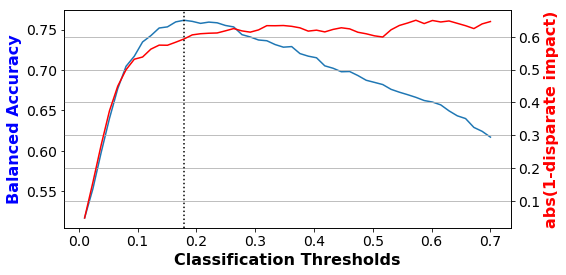

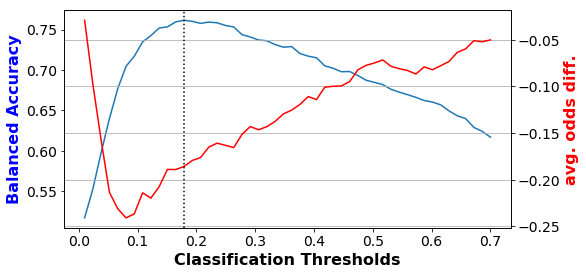

In [8]:
threshold_lr = validate_visualize(meps_orig_validate,
                                  model_lr.predict_proba(meps_orig_validate.features))

#### 3.2.2.3. Testing LR model from original data

In [9]:
values = validate_test(meps_orig_test,
              model_lr.predict_proba(meps_orig_test.features),
              threshold_lr)

values["method"] = "Logistic Regression"
metrics_df = pd.DataFrame(columns=values.keys())
metrics_df = metrics_df.append(values, ignore_index=True)

Threshold corresponding to Best balanced accuracy: 0.1790
Best balanced accuracy: 0.7704
Corresponding abs(1-disparate impact) value: 0.5703
Corresponding average odds difference value: -0.2075
Corresponding statistical parity difference value: -0.2717
Corresponding equal opportunity difference value: -0.2082
Corresponding Theil index value: 0.0927


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

abs(1-disparate impact) is typically desired to be < 0.2 for classifier predictions to be fair.

However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

Similarly, average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.

For a logistic regression classifier trained with original training data, at the best classification rate, this is still high. This still implies unfairness.

<a id="rf_orig"></a>

### 3.3. Bias Mitigation using pre-processing technique - Reweighing

#### 3.3.1. Transform data

In [10]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(meps_orig_train)
meps_trans_train = RW.transform(meps_orig_train)

<a id="reweighing-2015-metrics"></a>

#### 3.3.2. Metrics for transformed data

In [11]:
metric_meps_transf_train = BinaryLabelDatasetMetric(meps_trans_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % \
                                                  metric_meps_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between privileged and unprivileged groups = 0.000000


<a id="lr_transf"></a>

#### 3.3.3. Learning Logistic Regression (LR) classifier from data transformed by reweighing

#### 3.3.3.1. Training LR model after reweighing

In [12]:
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear'))
X_train = meps_trans_train.features
y_train = meps_trans_train.labels.ravel()

model_lr_trans = model.fit(X_train, y_train,
                     **{"logisticregression__sample_weight":meps_trans_train.instance_weights})

<a id="lr-rw-validate"></a>

#### 3.3.3.2. Validating  LR model after reweighing

100%|██████████| 50/50 [00:00<00:00, 152.73it/s]


Threshold corresponding to Best balanced accuracy: 0.1931
Best balanced accuracy: 0.7576
Corresponding abs(1-disparate impact) value: 0.2507
Corresponding average odds difference value: -0.0073
Corresponding statistical parity difference value: -0.0915
Corresponding equal opportunity difference value: 0.0148
Corresponding Theil index value: 0.0928


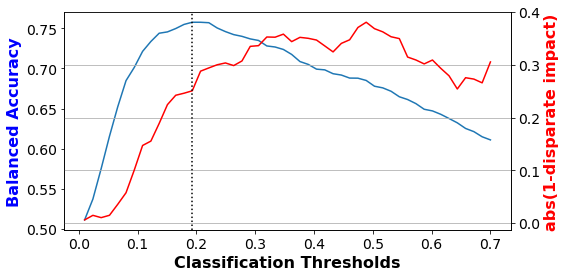

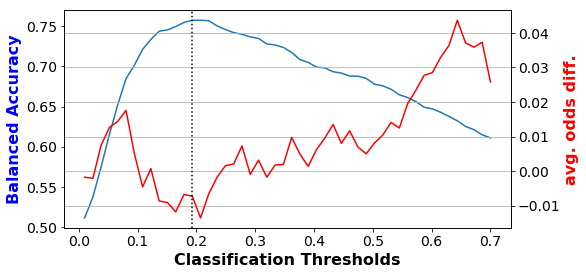

In [13]:
threshold_lr_trans = validate_visualize(meps_orig_validate,
                                        model_lr_trans.predict_proba(meps_orig_validate.features))

#### 3.3.3.3. Testing  LR model after reweighing

In [14]:
values = validate_test(meps_orig_test,
                       model_lr_trans.predict_proba(meps_orig_test.features),
                       threshold_lr_trans)

values["method"] = "LR - Reweighing"
metrics_df = metrics_df.append(values, ignore_index=True)

Threshold corresponding to Best balanced accuracy: 0.1931
Best balanced accuracy: 0.7639
Corresponding abs(1-disparate impact) value: 0.2354
Corresponding average odds difference value: -0.0241
Corresponding statistical parity difference value: -0.0899
Corresponding equal opportunity difference value: -0.0264
Corresponding Theil index value: 0.0936


The fairness metrics for the logistic regression model learnt after reweighing are fairly improved, and thus the model is much more fair relative to the logistic regression model learnt from the original data.

<a id="rf_transf"></a>

<a id="kamishima"></a>

### 3.4. Bias Mitigation using in-processing technique - Prejudice Remover (PR)

#### 3.4.1. Training PR model

In [15]:
tr_dataset = meps_orig_train.copy(deepcopy=True)

model = PrejudiceRemover(sensitive_attr=sens_attr, eta = 25.0)
scale = StandardScaler().fit(tr_dataset.features)

tr_dataset.features = scale.transform(tr_dataset.features)
model.fit(tr_dataset)

#save model
meps_orig_pr = model
meps_orig_pr_scale = scale

<a id="ks-validate"></a>

#### 3.4.2. Validating PR model

100%|██████████| 50/50 [00:00<00:00, 166.47it/s]


Threshold corresponding to Best balanced accuracy: 0.1227
Best balanced accuracy: 0.6846
Corresponding abs(1-disparate impact) value: 0.2315
Corresponding average odds difference value: 0.0239
Corresponding statistical parity difference value: -0.0834
Corresponding equal opportunity difference value: 0.1135
Corresponding Theil index value: 0.1122


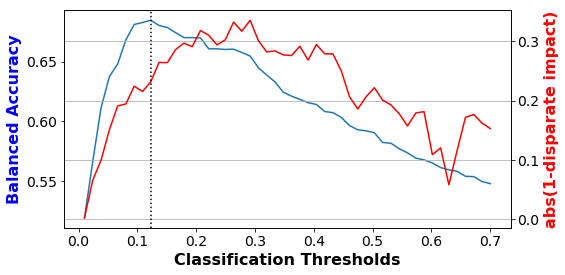

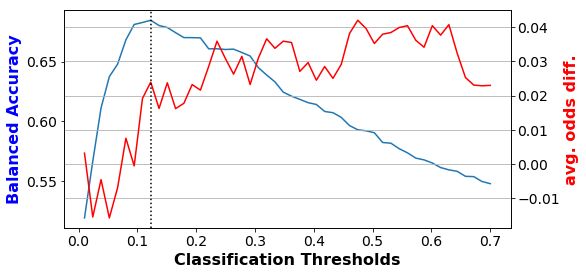

In [16]:
te_dataset= meps_orig_validate.copy(deepcopy=True)
te_dataset.features = meps_orig_pr_scale.transform(te_dataset.features)
pred_dataset = meps_orig_pr.predict(te_dataset)
y_validate_pred_prob = pred_dataset.scores

threshold_pr = validate_visualize(meps_orig_validate,
                                  y_validate_pred_prob)

<a id="ks-test"></a>

#### 3.4.3. Testing PR model

In [17]:
te_dataset= meps_orig_test.copy(deepcopy=True)
te_dataset.features = meps_orig_pr_scale.transform(te_dataset.features)
pred_dataset = meps_orig_pr.predict(te_dataset)
y_data_pred_prob = pred_dataset.scores

values = validate_test(te_dataset,
                       y_data_pred_prob,
                       threshold_pr)
values["method"] = "Prejudice Remover"
metrics_df = metrics_df.append(values, ignore_index=True)

Threshold corresponding to Best balanced accuracy: 0.1227
Best balanced accuracy: 0.6813
Corresponding abs(1-disparate impact) value: 0.1767
Corresponding average odds difference value: 0.0389
Corresponding statistical parity difference value: -0.0622
Corresponding equal opportunity difference value: 0.1252
Corresponding Theil index value: 0.1123


As in the case of re-weighing, prejudice remover has resulted in a fair model. However, it hs come at an expense of relative lower balanced accuracy.

<a id="disparate-impact"></a>

### 3.5. Bias mitigation using pre-processing technique - Disparate Impact (DIR) Remover

#### 3.5.1. Training DIR model

In [18]:
tr_dataset = meps_orig_train.copy(deepcopy=True)
scale = MinMaxScaler().fit(tr_dataset.features)   # remember the scale
tr_dataset.features = scale.transform(tr_dataset.features)
index = tr_dataset.feature_names.index(sens_attr)

di = DisparateImpactRemover(repair_level=1.0)
train_repd = di.fit_transform(tr_dataset) #repair training dataset

X_tr = np.delete(train_repd.features, index, axis=1)
y_tr = train_repd.labels.ravel()

model = LogisticRegression(random_state = 1, class_weight='balanced',
                           solver='liblinear')
model.fit(X_tr, y_tr)

meps_orig_dir_scale = scale
meps_orig_dir = model

<a id="di-validate"></a>

#### 3.5.2. Validating DIR model

100%|██████████| 50/50 [00:00<00:00, 165.12it/s]


Threshold corresponding to Best balanced accuracy: 0.5733
Best balanced accuracy: 0.7694
Corresponding abs(1-disparate impact) value: 0.5159
Corresponding average odds difference value: -0.1103
Corresponding statistical parity difference value: -0.1896
Corresponding equal opportunity difference value: -0.0970
Corresponding Theil index value: 0.0930


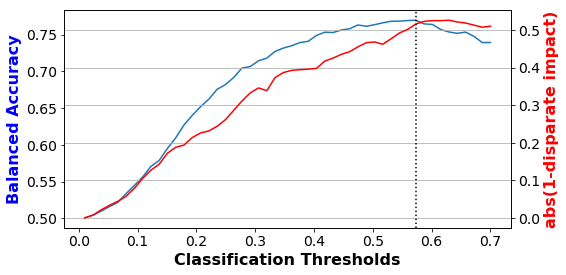

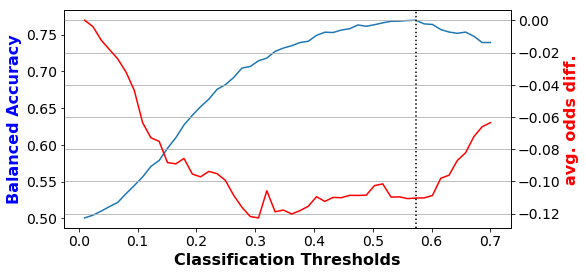

In [19]:
te_dataset= meps_orig_validate.copy(deepcopy=True)
te_dataset.features = meps_orig_dir_scale.transform(te_dataset.features)
validate_repd = di.fit_transform(te_dataset)  #repair validate dataset
X_te = np.delete(validate_repd.features, index, axis=1)
y_te_pred_prob = meps_orig_dir.predict_proba(X_te)

threshold_dir = validate_visualize(te_dataset,
                                   y_te_pred_prob)

#### 3.5.3. Testing DIR model

In [20]:
te_dataset= meps_orig_test.copy(deepcopy=True)
te_dataset.features = meps_orig_dir_scale.transform(te_dataset.features)

di = DisparateImpactRemover(repair_level=1.0)

test_repd = di.fit_transform(te_dataset)  #repair test dataset

index = te_dataset.feature_names.index(sens_attr)        
X_te = np.delete(test_repd.features, index, axis=1)

y_te_pred_prob = meps_orig_dir.predict_proba(X_te)

values = validate_test(te_dataset,
                       y_te_pred_prob,
                       threshold_dir)
values["method"] = "LR - Disparate Impact Remover"
metrics_df = metrics_df.append(values, ignore_index=True)

Threshold corresponding to Best balanced accuracy: 0.5733
Best balanced accuracy: 0.7667
Corresponding abs(1-disparate impact) value: 0.4425
Corresponding average odds difference value: -0.0956
Corresponding statistical parity difference value: -0.1631
Corresponding equal opportunity difference value: -0.0937
Corresponding Theil index value: 0.0947


While disparate impact remover resulted in a model that is relatively fairer than, for examaple, the logistic regression model learnt from original data, it is quite unfair with an abs(1-disparate impact) value much higher than the typically desired value of < 0.2

<a id="summary-2015-learning"></a>

### 3.6. Summary of MEPS Model Learning Results

In [21]:
metrics_df.set_index('method')

,best_bal_acc,disp_imp,avg_odds_diff,stat_par_diff,eq_opp_diff,theil_ind
method,,,,,,
Logistic Regression,0.770385,0.570281,-0.207482,-0.271703,-0.208154,0.092654
LR - Reweighing,0.763861,0.235404,-0.024100,-0.089920,-0.026399,0.093623
Prejudice Remover,0.681270,0.176694,0.038889,-0.062227,0.125215,0.112331
LR - Disparate Impact Remover,0.766683,0.442499,-0.095615,-0.163094,-0.093719,0.094684


Of all the models, the logistic regression model after reweighing gives the best balance in terms of balanced accuracy and fairness. While the model learnt by prejudice remover is slightly fairer, it has much lower accuracy. 

<a id="deployment-2015-2015"></a>